In [1]:
### Imports
import os
import sys
sys.path.append('C:\\Users\\szb37\\My Drive\\Projects\\Unmasking power\\UP codebase')
from statsmodels.stats.proportion import proportion_confint
import src.folders as folders
import src.power as power
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 300  # Set display DPI
plt.rcParams.update({'font.family': 'arial'})
title_fontdict = {'fontsize': 16, 'fontweight': 'bold'}
axislabel_fontdict = {'fontsize': 14, 'fontweight': 'bold'}
ticklabel_fontsize = 12

dir_out=os.path.join(folders.exports, 'Bayesian')
def save_fig(fig, fname, dir_out=dir_out):
    for fileformat in ['png', 'svg']:
        fig.savefig(
            fname=os.path.join(dir_out, f'{fname}.{fileformat}'),
            bbox_inches='tight',
            format=fileformat,
            dpi=300,)

n_draws = 300
n_trials = 200
sample = 200

In [ ]:
### Generate mock data
# We will sample this df; precompute for convenience


# df_patientsData => range of CGRs
cgrs = [round(float(cgr), 2) for cgr in np.arange(0, 1.01, 0.02)]
df_patientsData=[]
for cgr in cgrs:
    df_patientsData.append(
        power.DataGeneration.get_df_patientsData(
            scenario = f'{cgr}', 
            n_trials = n_trials, 
            sample = sample, 
            params = [{
                'type': 'binaryguess',
                'arm_params':{
                    'C': {'cgr': cgr},
                    'T': {'cgr': cgr},},}]))       
df_patientsData = pd.concat(df_patientsData, ignore_index=True)
df_patientsData['cgr'] = pd.to_numeric(df_patientsData['scenario'], errors='coerce')
del df_patientsData['scenario']
df_patientsData = df_patientsData[['cgr','trial','pID','trt','guess_bin',]]
# df_patientsData.head()

Calculate df_bayes of IRL trials

In [ ]:
### Calculate df_bayes for trials - can take a while, results are pre-calculated, see next cell

df_bayes =[]

df_bayes.append(
    get_df_bayes(
        df_patientsData = df_patientsData, 
        trial_name= 'Avery',
        n_match = 32,
        n_obs = 63,))

df_bayes.append(
    get_df_bayes(
    df_patientsData = df_patientsData, 
    trial_name= 'Jelovac',
    n_match = 38,
    n_obs = 60,))

df_bayes.append(
    get_df_bayes(
        df_patientsData = df_patientsData, 
        trial_name= 'Richards',
        n_match = 57,
        n_obs = 97,))

df_bayes.append(
    get_df_bayes(
        df_patientsData = df_patientsData, 
        trial_name= 'Sloshower',
        n_match = 27,
        n_obs = 34,))

# df_bayes = get_df_bayes(
#     df_patientsData = df_patientsData, 
#     trial_name= 'Lewis',
#     n_match = 348,
#     n_obs = 552,)

# df_bayes = get_df_bayes(
#     df_patientsData = df_patientsData, 
#     trial_name= 'POP',
#     n_match = 20,
#     n_obs = 24,)

df_bayes = pd.concat(df_bayes)

In [2]:
### Save / load df_bayes
#df_bayes.to_csv(os.path.join(dir_out, 'df_bayes.csv'), index=False)
df_bayes = pd.read_csv(os.path.join(dir_out, 'df_bayes.csv'))

Setup experiments

In [ ]:
### Impact of CI and sample size

# mean CGR:0.7
# small CI: (0.65, 0.75)
# large CI: (0.55, 0.85)
# small sample: 50
# large sample: 150

df_bayes =[]
df_bayes.append(
    power.BayesStats.get_df_bayes(
        df_patientsData = df_patientsData, 
        trial_name= 'smallCI_smallSample',
        n_obs = 50,
        target_ci = (0.65, 0.75)))
df_bayes.append(
    power.BayesStats.get_df_bayes(
        df_patientsData = df_patientsData, 
        trial_name= 'smallCI_largeSample',
        n_obs = 150,
        target_ci = (0.65, 0.75)))
df_bayes.append(
    power.BayesStats.get_df_bayes(
        df_patientsData = df_patientsData, 
        trial_name= 'largeCI_smallSample',
        n_obs = 50,
        target_ci = (0.55, 0.85)))
df_bayes.append(
    power.BayesStats.get_df_bayes(
        df_patientsData = df_patientsData, 
        trial_name= 'largeCI_largeSample',
        n_obs = 150,
        target_ci = (0.55, 0.85)))

df_bayes = pd.concat(df_bayes)
power.BayesStats.get_df_posterior_sum(df_bayes)

Run analysis

In [3]:
### Calc posterior sum in ranges of interest 
df_posterior_sum = power.BayesStats.get_df_posterior_sum(df_bayes)
df_posterior_sum.to_csv(os.path.join(dir_out, 'df_posterior_sum.csv'), index=False)
df_posterior_sum

,trial,"(0.0, 0.375)","(0.375, 0.625)","(0.625, 1.0)"
0,Avery,0.080,0.813,0.106
1,Jelovac,0.003,0.526,0.471
2,Richards,0.003,0.692,0.305
3,Sloshower,0.000,0.141,0.859


In [4]:
### Calc marginal Likelihoods
power.BayesStats.get_df_mrg_llhood(df_bayes)

,trial,"(0.0, 0.375)","(0.375, 0.625)","(0.625, 1.0)"
0,Avery,0.018,0.186,0.024
1,Jelovac,0.001,0.118,0.106
2,Richards,0.001,0.131,0.058
3,Sloshower,0.000,0.035,0.216


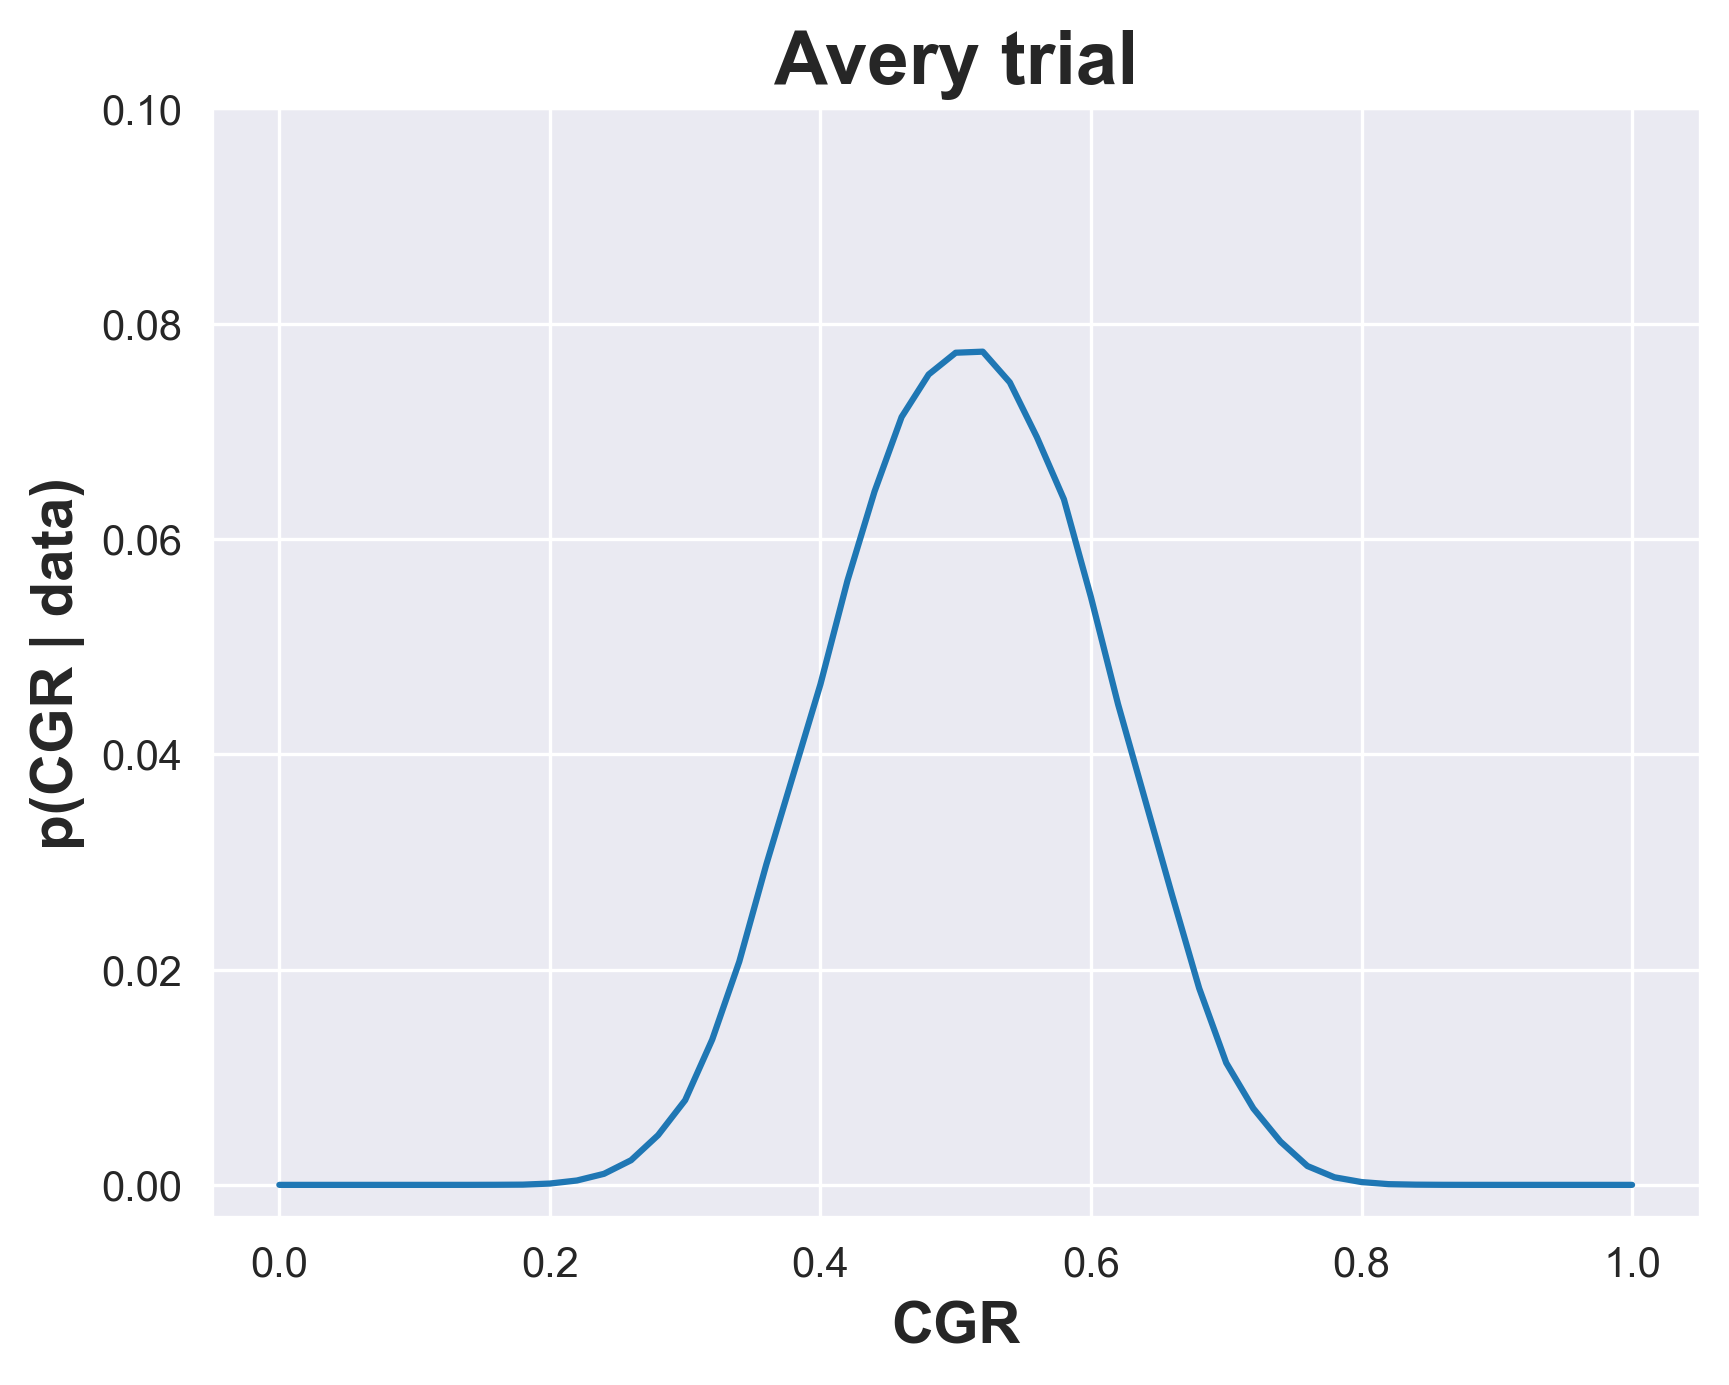

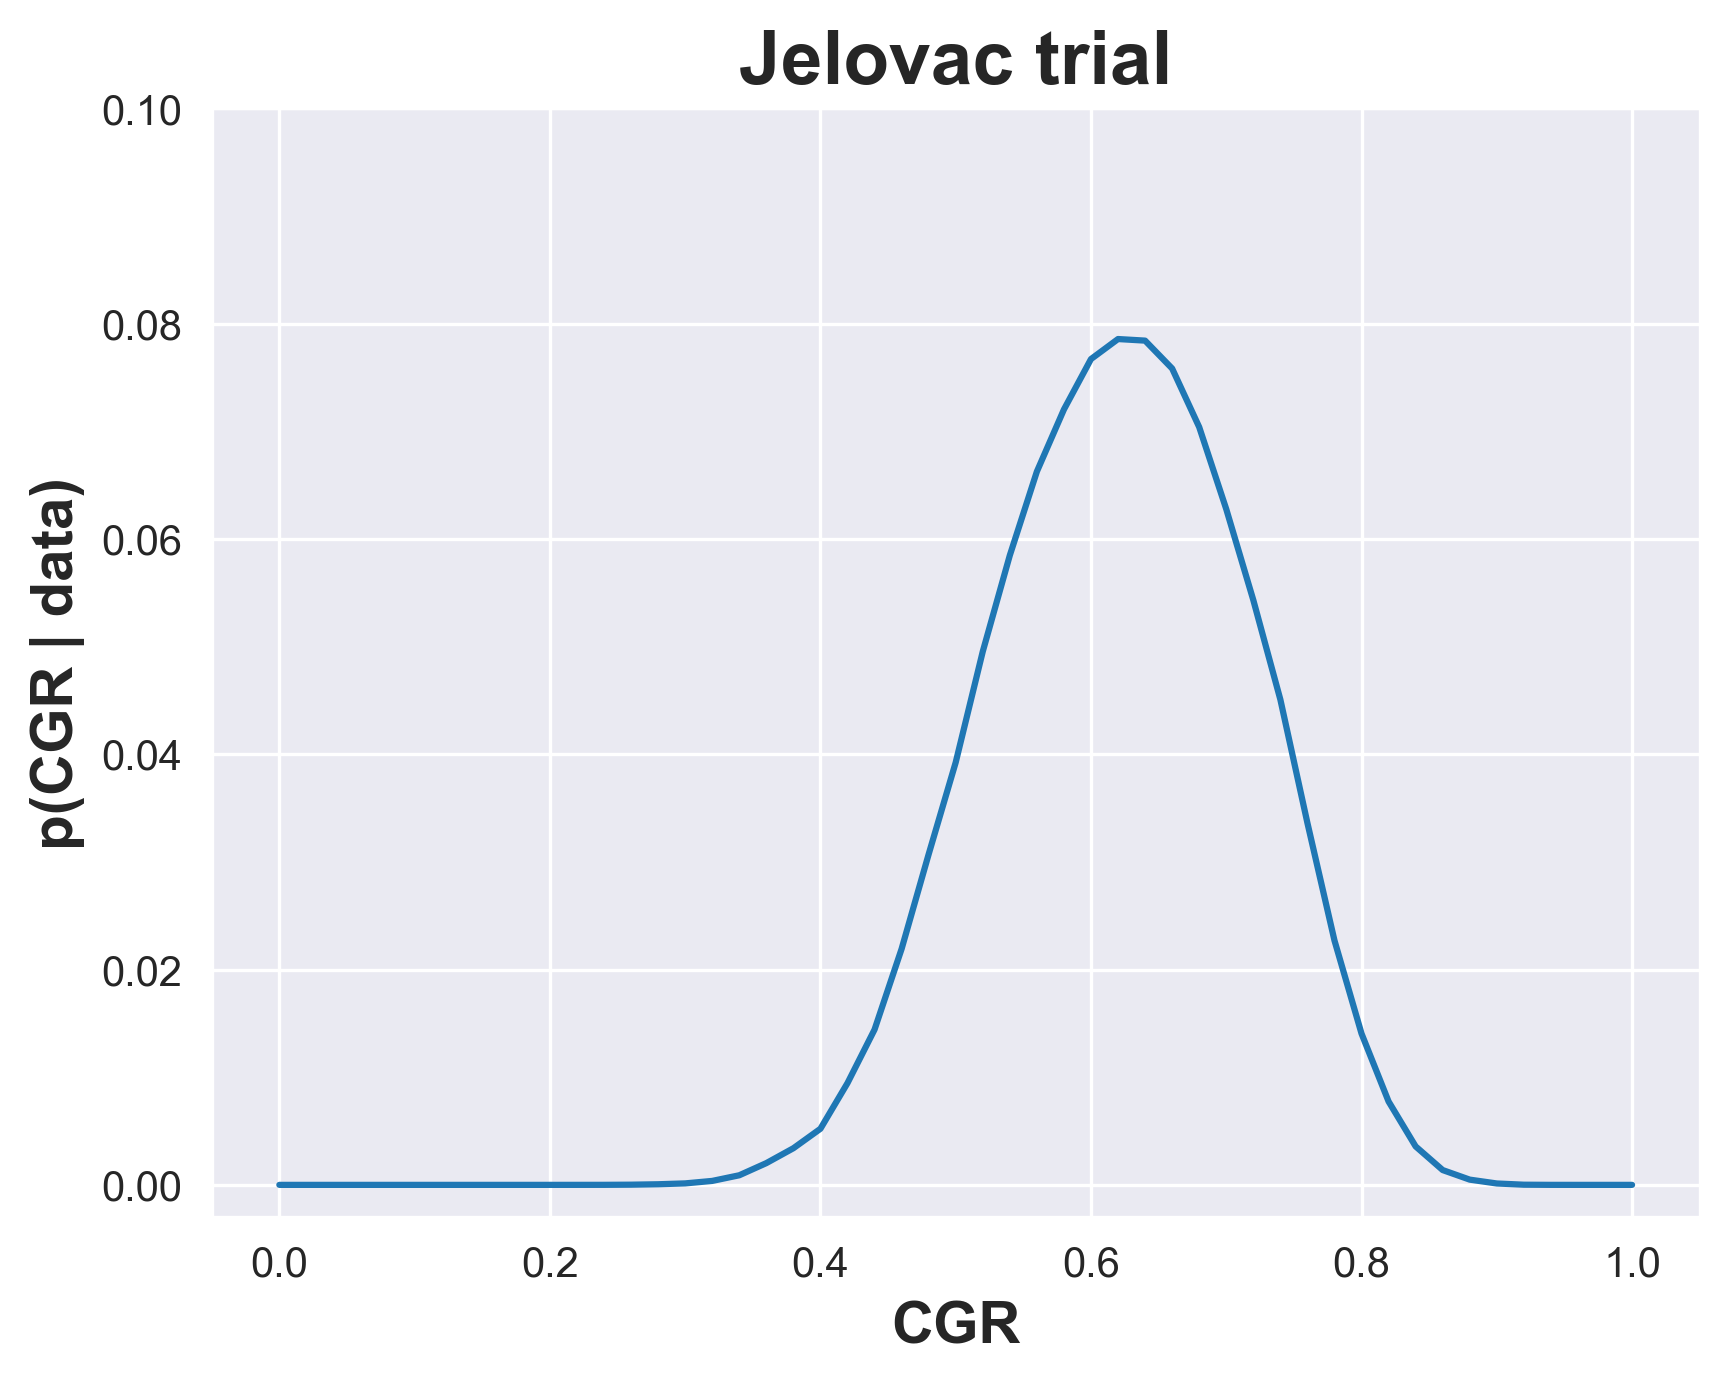

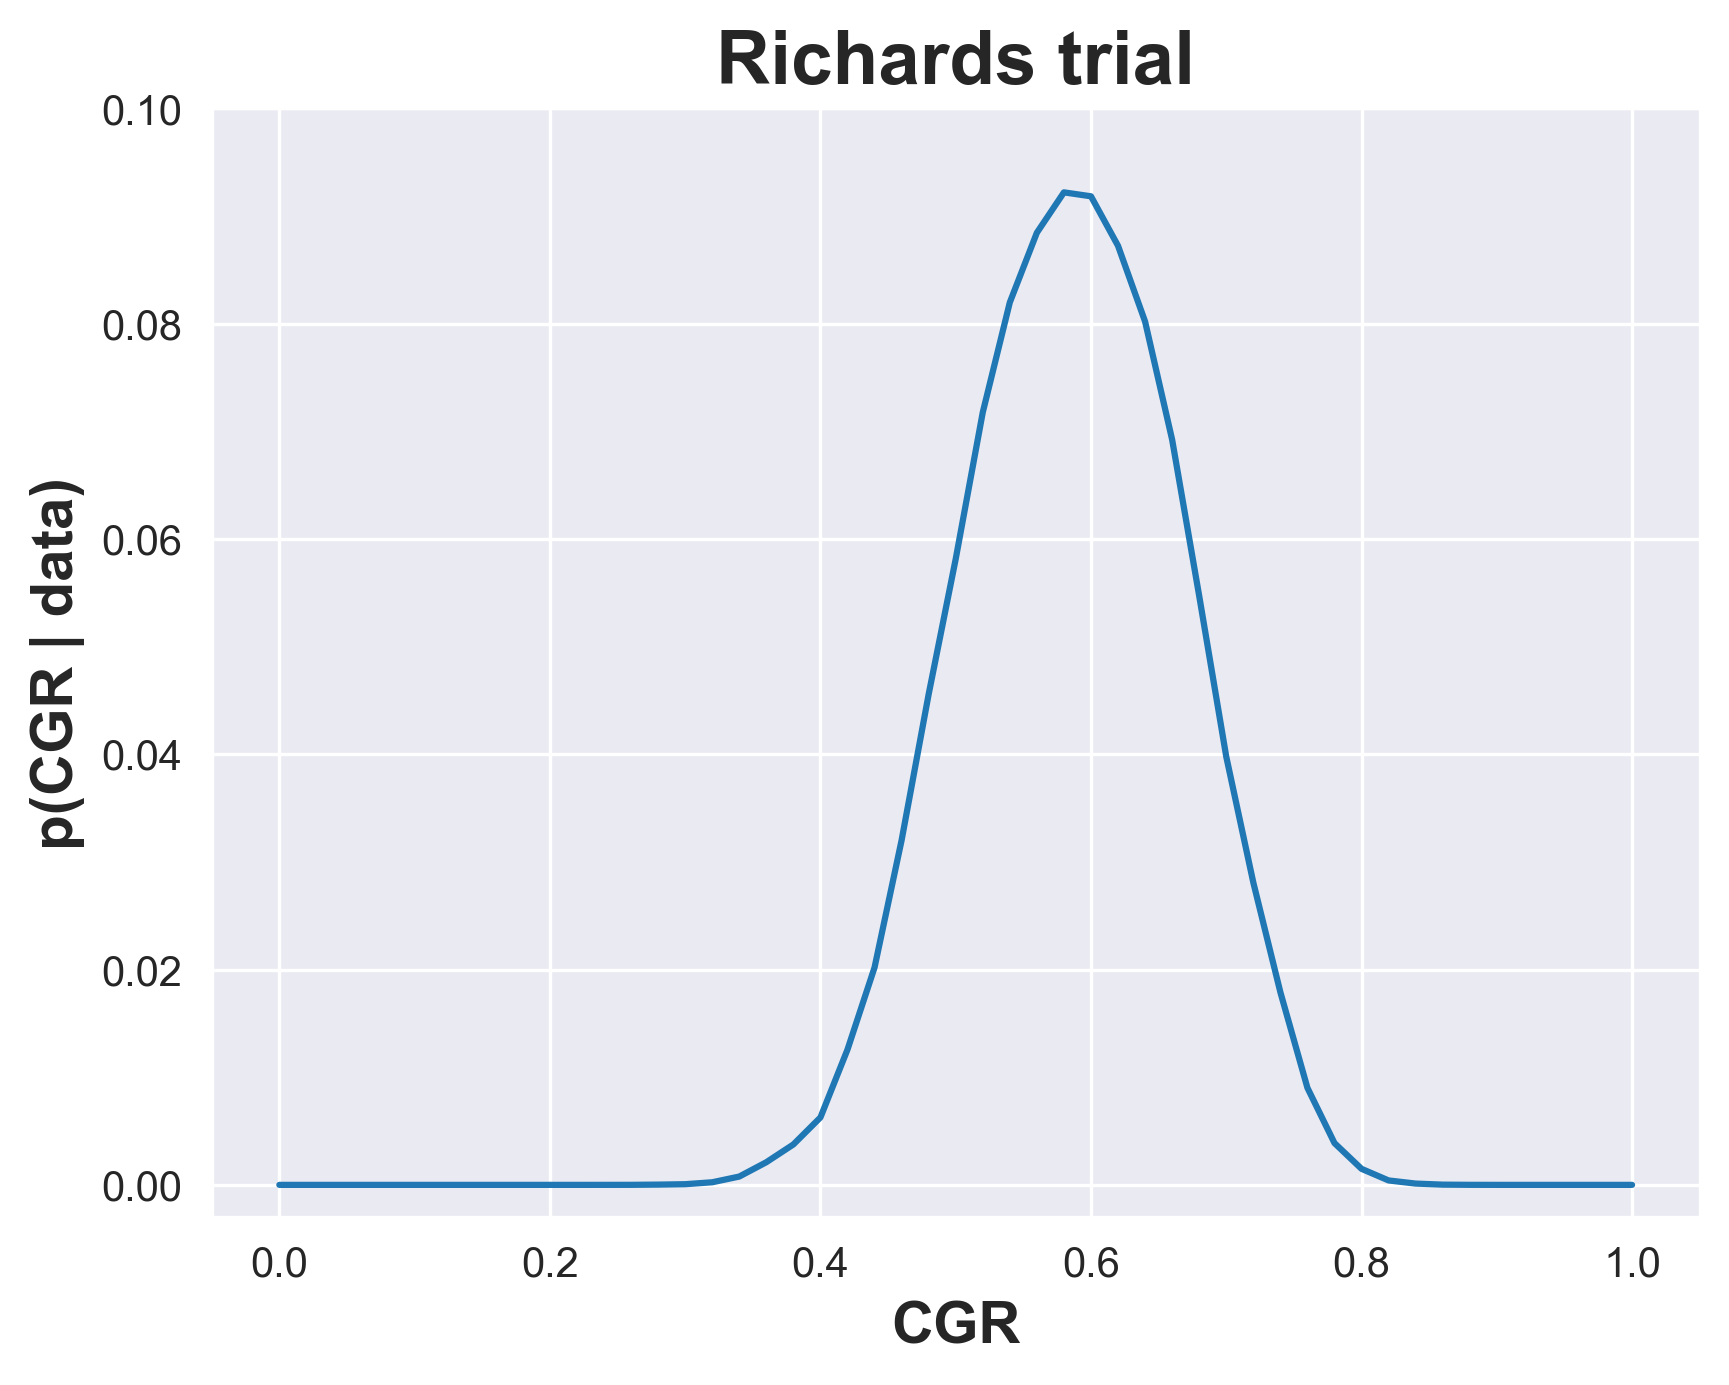

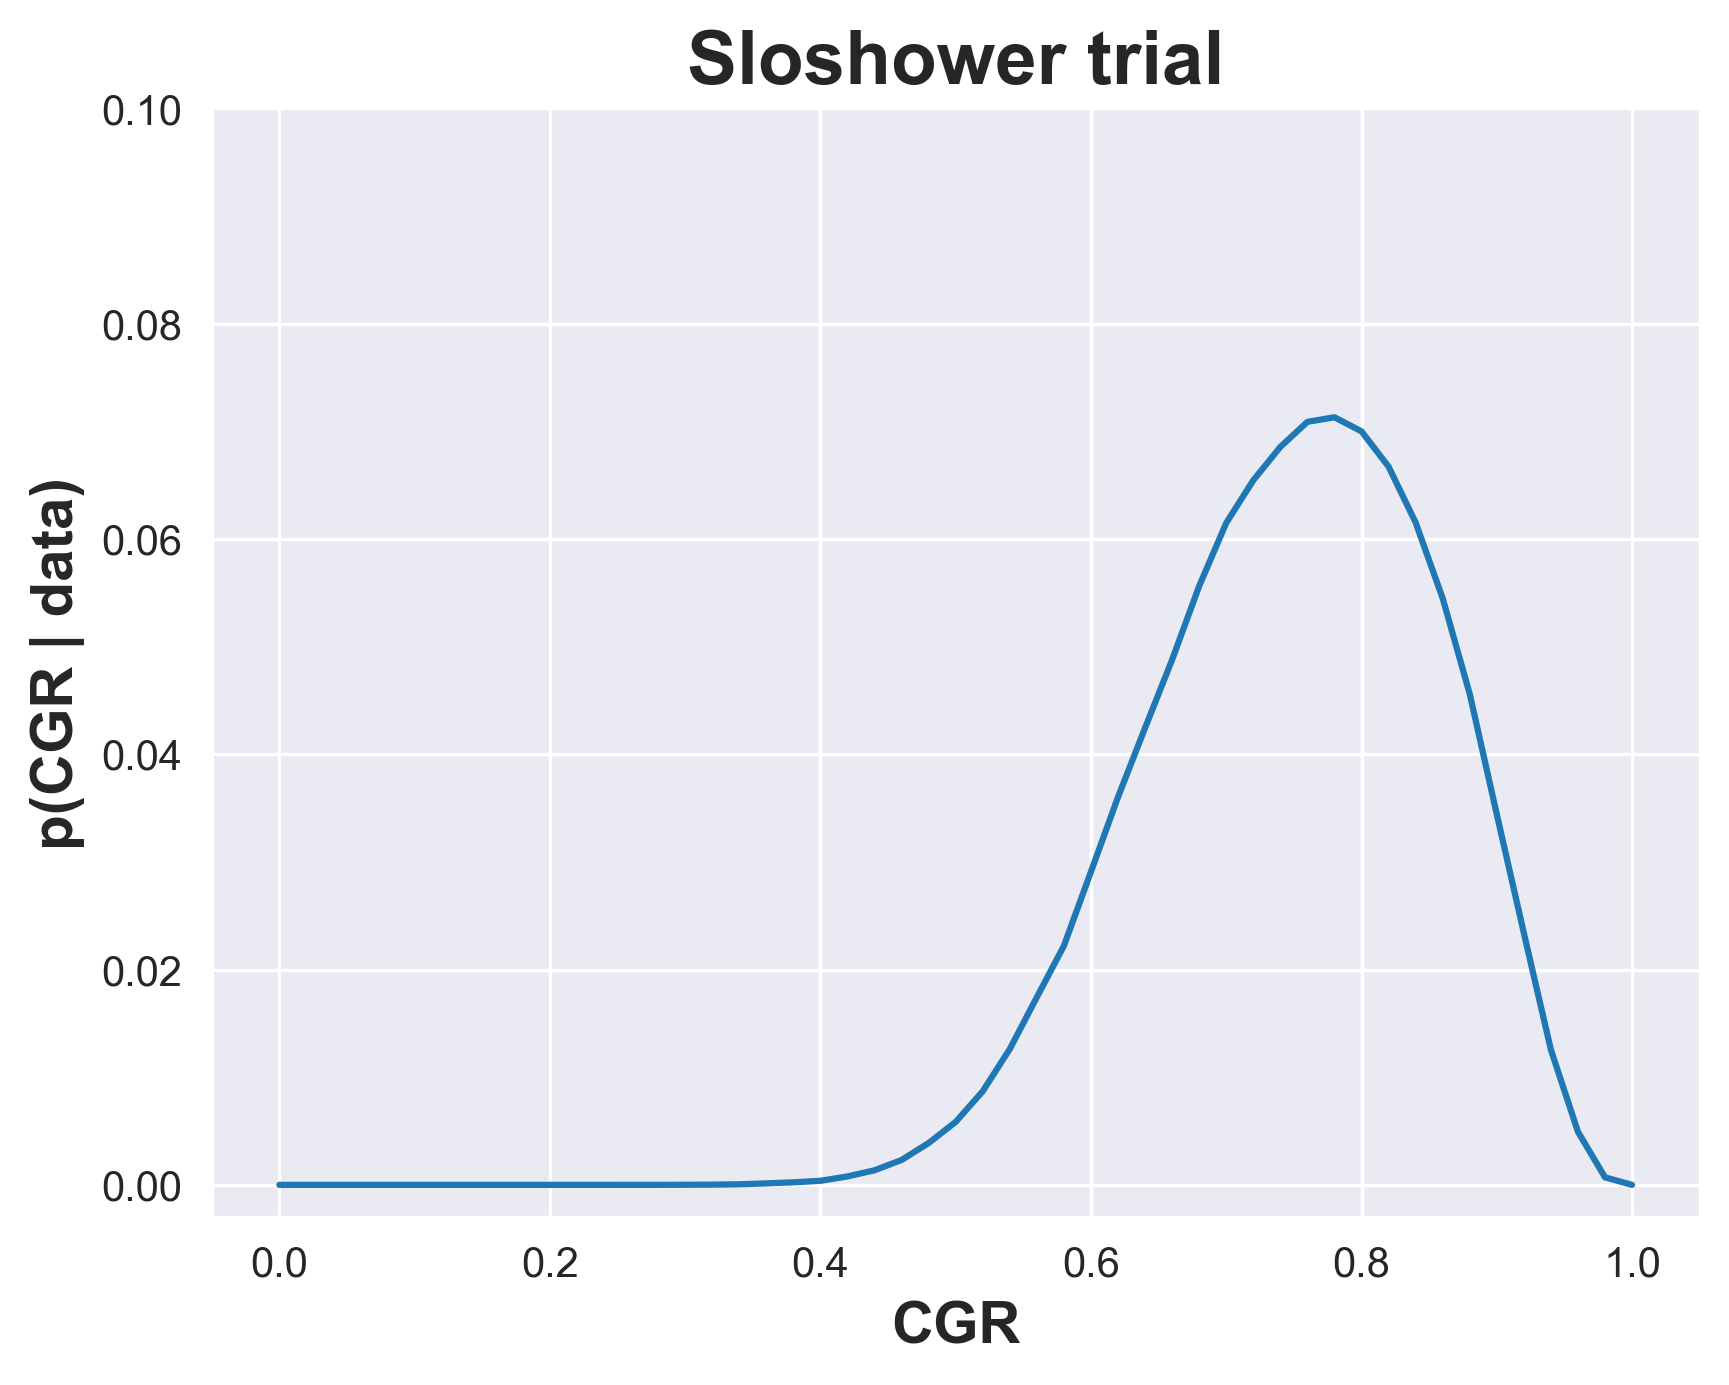

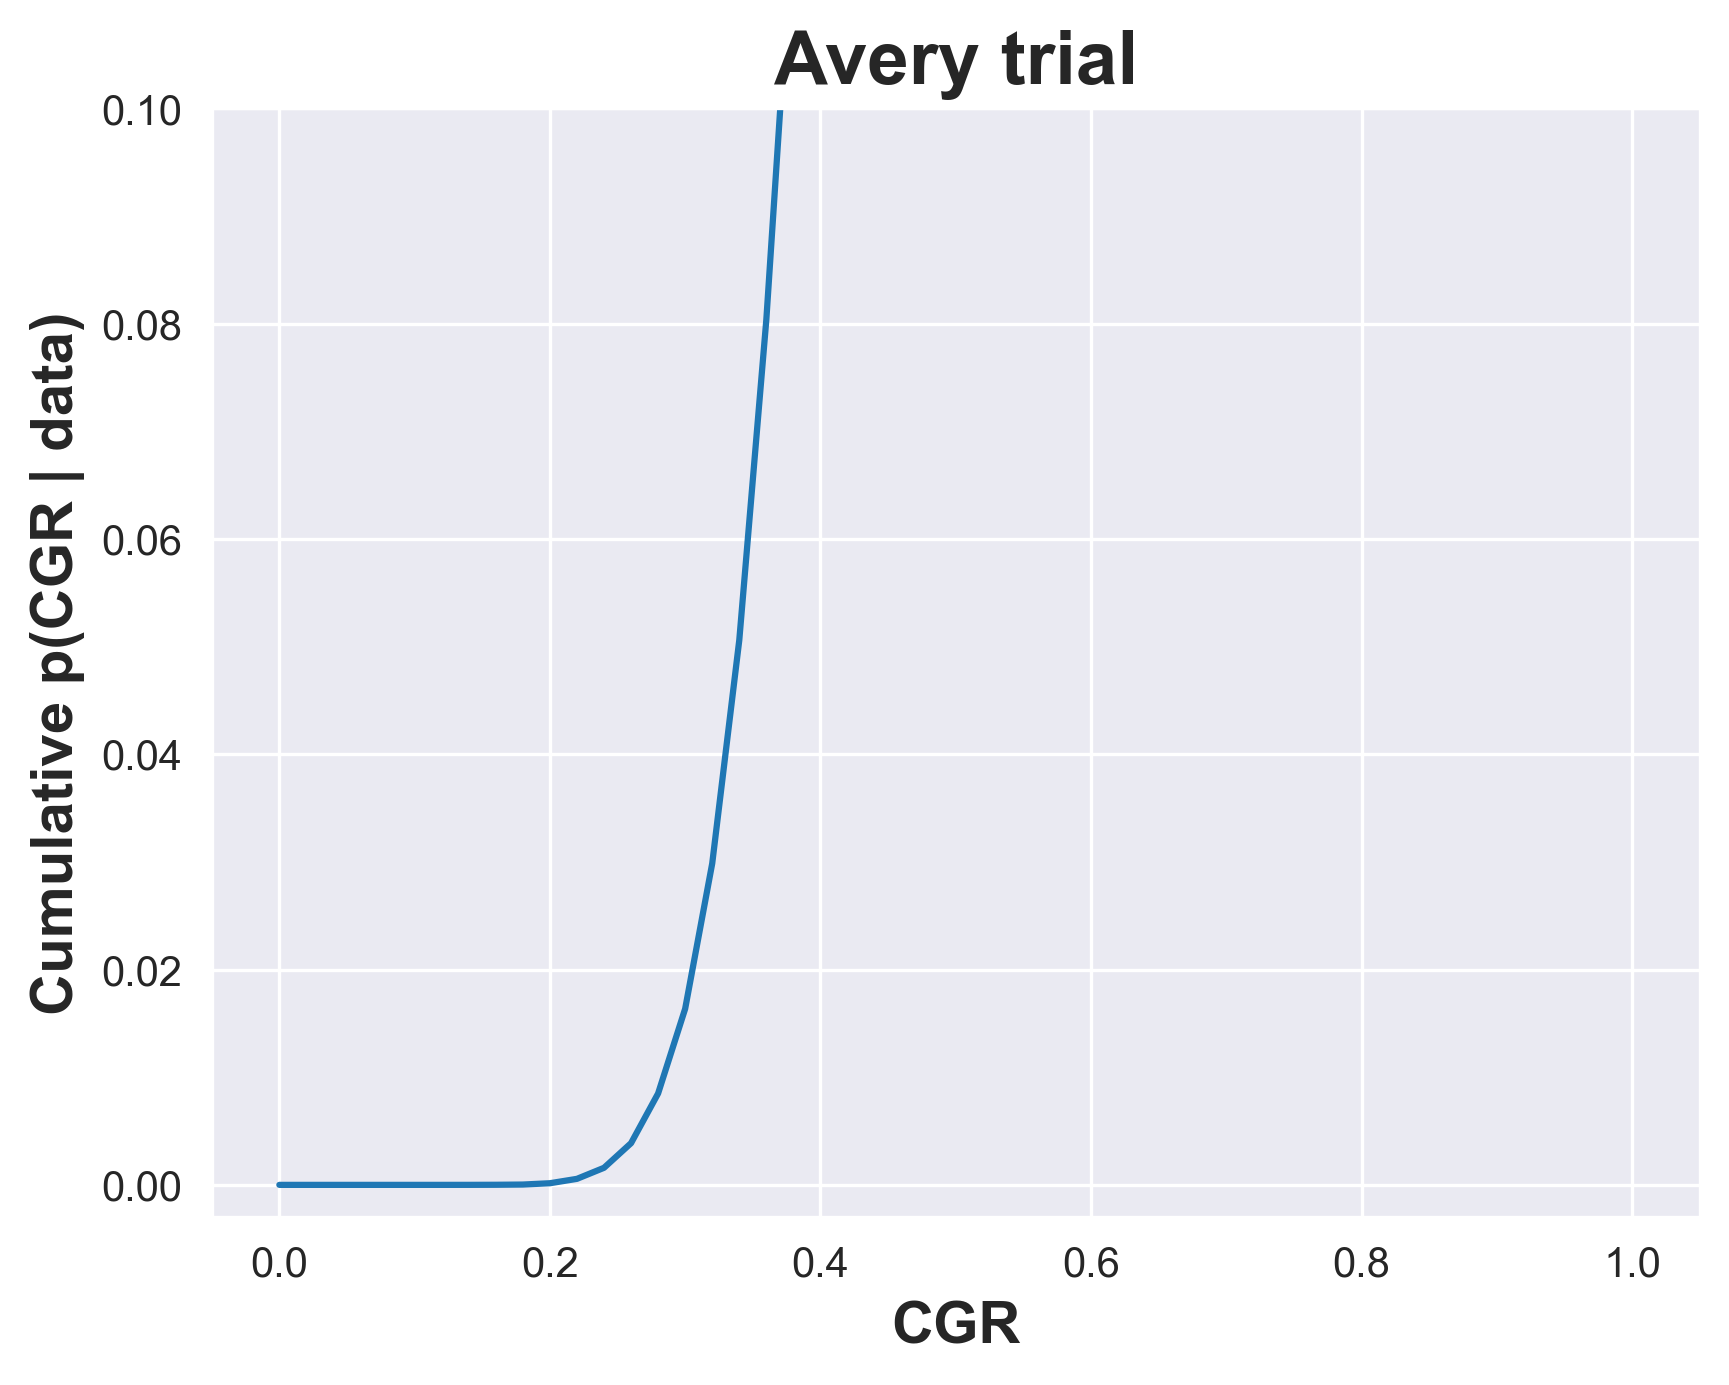

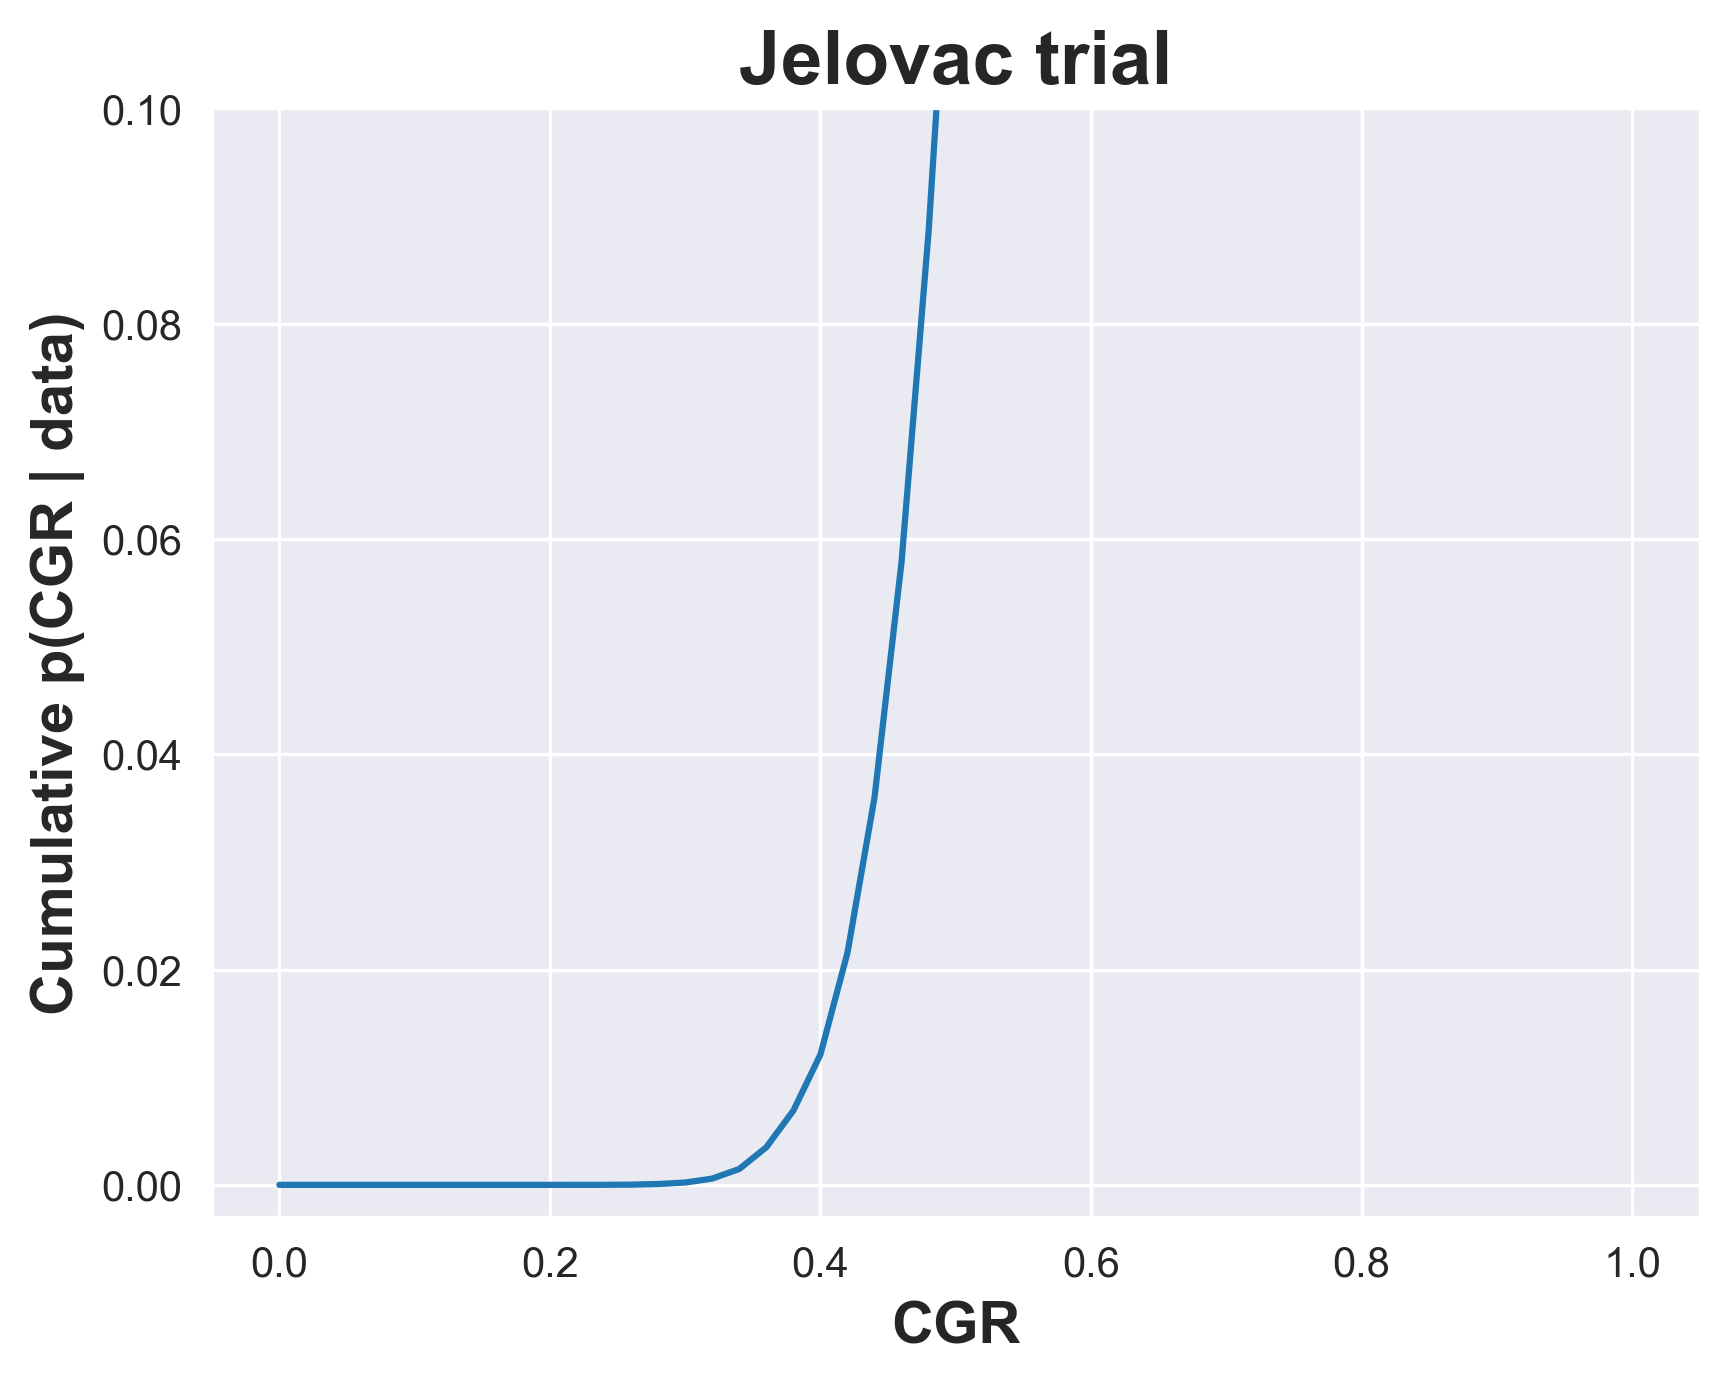

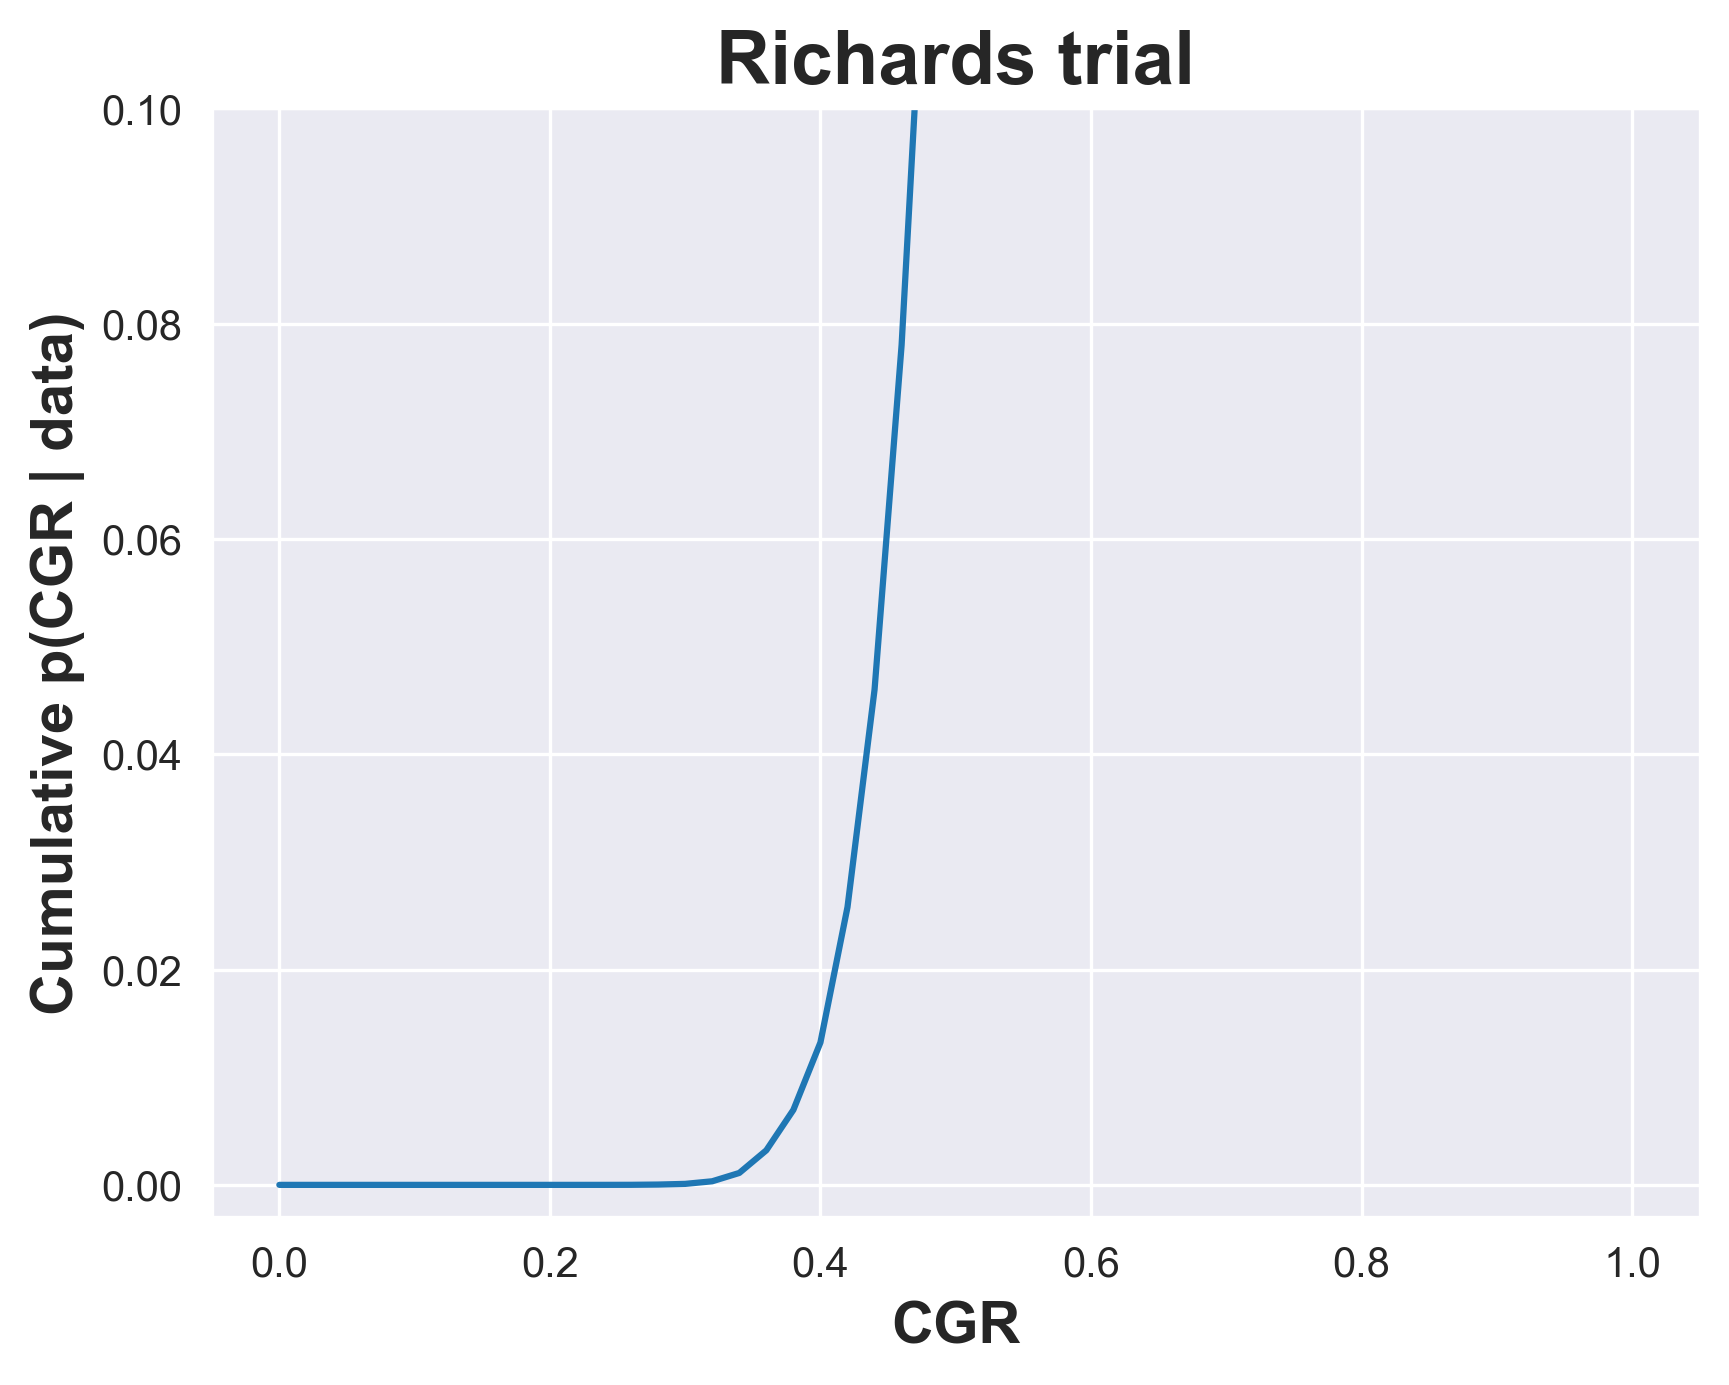

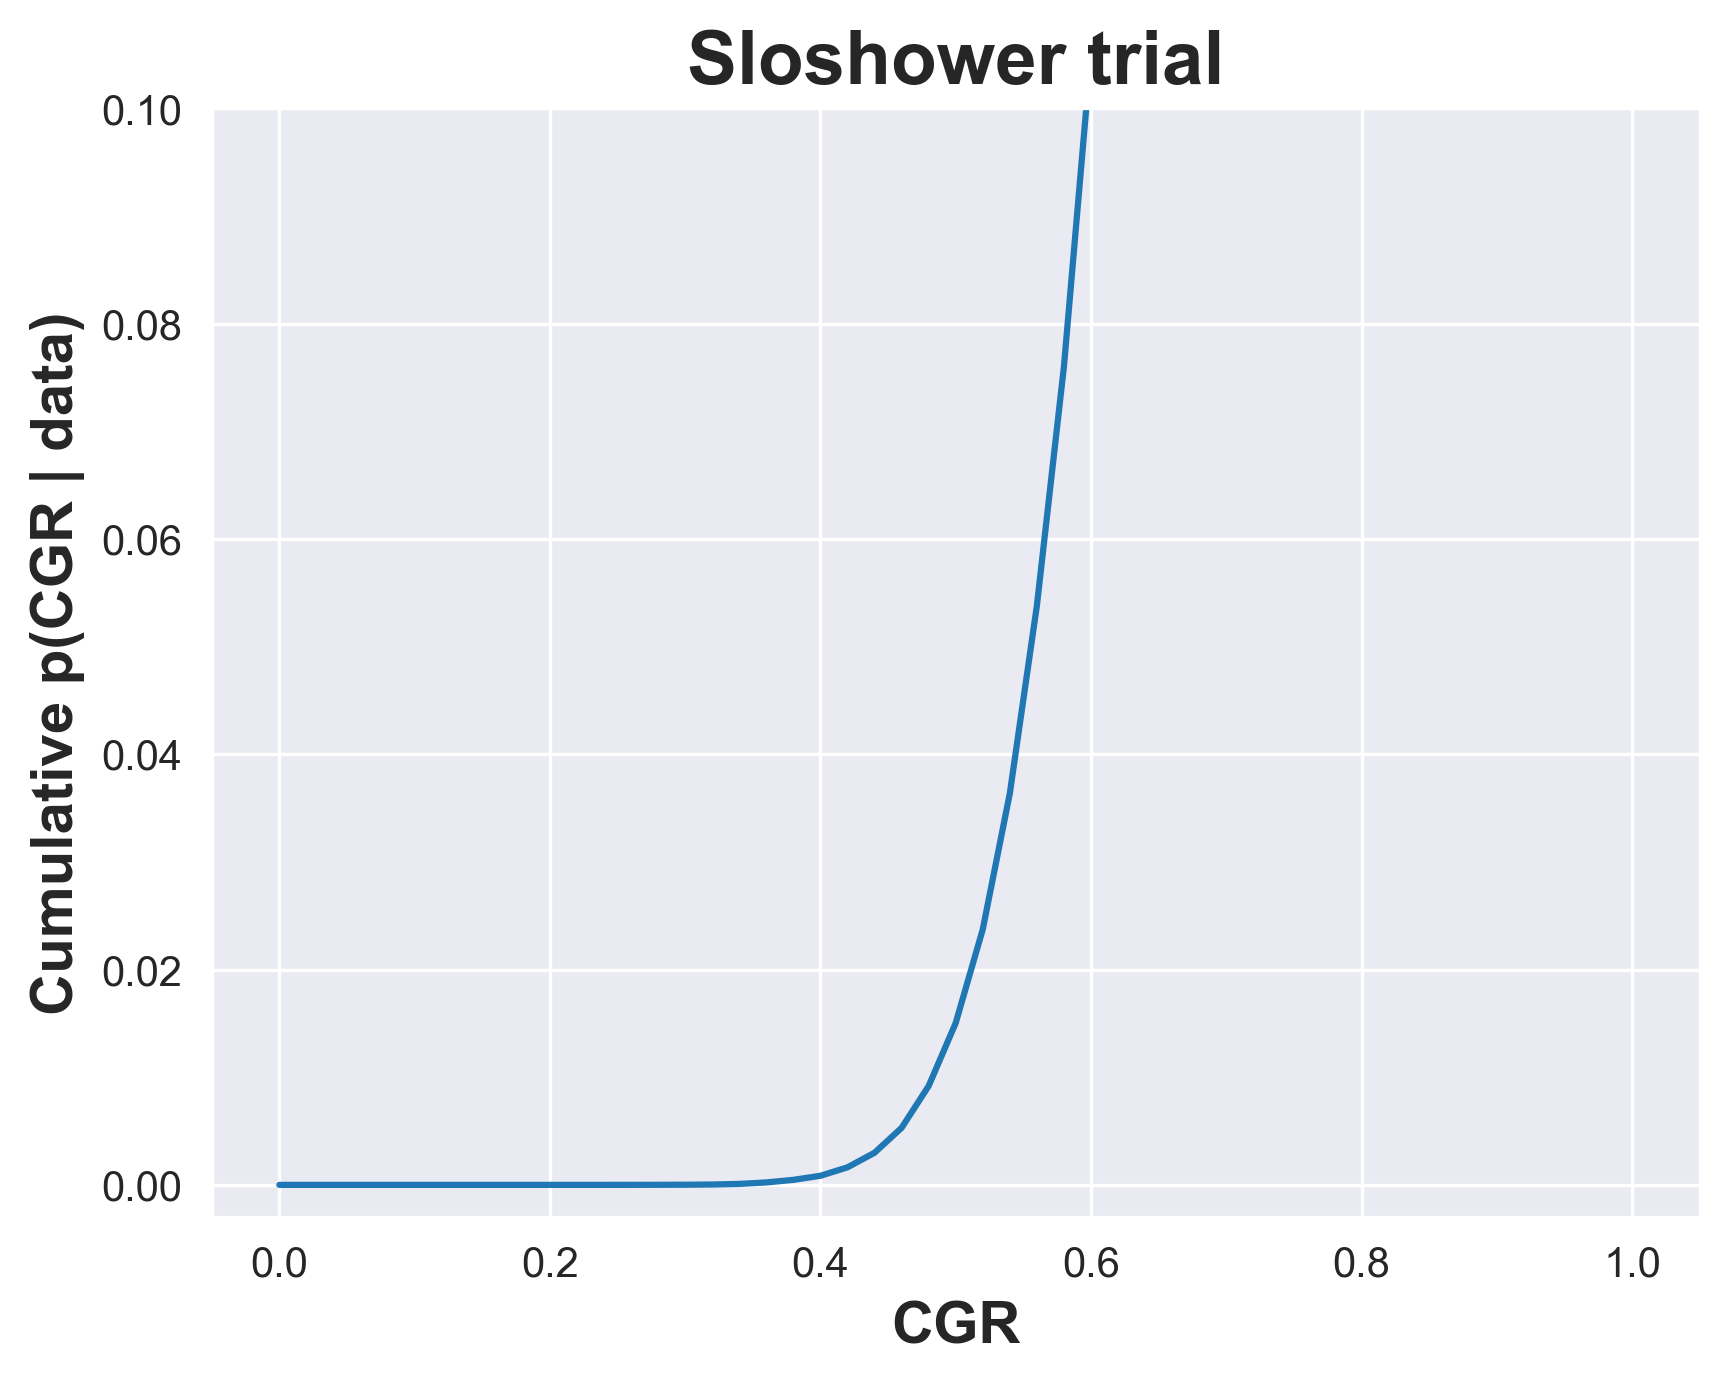

In [5]:
### Draw posteriors
power.BayesStats.draw_posterior(df_bayes, cumulative=False)
power.BayesStats.draw_posterior(df_bayes, cumulative=True)